In [ ]:
#install pyspark
!pip install pyspark



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 40 kB/s 
     |████████████████████████████████| 199 kB 56.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=603997b70377ef9e8b6e9f756b10b247353e4797e6908f771ad7736e6b075689
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [ ]:
# Spark SQL
!pip install pyspark[sql]
# pandas API on Spark
!pip install pyspark[pandas_on_spark] plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 1. Create a Spark session

In [107]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("crime_analysis").getOrCreate()

### 2. Define the schema for loading the Chicago crime dataset

In [108]:
from pyspark.sql.types import  (StructType, 
                                StructField, 
                                DateType, 
                                BooleanType,
                                DoubleType,
                                IntegerType,
                                StringType,
                               TimestampType)


crimes_schema = StructType([StructField("ID", StringType(), True),
                            StructField("CaseNumber", StringType(), True),
                            StructField("Date", StringType(), True ),
                            StructField("Block", StringType(), True),
                            StructField("IUCR", StringType(), True),
                            StructField("PrimaryType", StringType(), True  ),
                            StructField("Description", StringType(), True ),
                            StructField("LocationDescription", StringType(), True ),
                            StructField("Arrest", BooleanType(), True),
                            StructField("Domestic", BooleanType(), True),
                            StructField("Beat", StringType(), True),
                            StructField("District", StringType(), True),
                            StructField("Ward", StringType(), True),
                            StructField("CommunityArea", StringType(), True),
                            StructField("FBICode", StringType(), True ),
                            StructField("XCoordinate", DoubleType(), True),
                            StructField("YCoordinate", DoubleType(), True ),
                            StructField("Year", IntegerType(), True),
                            StructField("UpdatedOn", DateType(), True ),
                            StructField("Latitude", DoubleType(), True),
                            StructField("Longitude", DoubleType(), True),
                            StructField("Location", StringType(), True )
                            ])

### 3. Load the Chicago crime data (you should get more than a million rows)

In [109]:
Chicago_crimes = spark.read.csv("Crimes_-_2001_to_Present.csv",
                       header = True, 
                        schema = crimes_schema)

In [110]:
print(" The crimes dataframe has {} records".format(Chicago_crimes.count()))

 The crimes dataframe has 6579242 records


Note: Some data was lost(couldn't figure out the reason). SO working with the number of records that were available


### 4. Clean the data:
**a) Remove all null values.**


In [111]:
Chicago_crimes.na.drop().show()

+---+----------+----+-----+----+-----------+-----------+-------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+---------+--------+---------+--------+
| ID|CaseNumber|Date|Block|IUCR|PrimaryType|Description|LocationDescription|Arrest|Domestic|Beat|District|Ward|CommunityArea|FBICode|XCoordinate|YCoordinate|Year|UpdatedOn|Latitude|Longitude|Location|
+---+----------+----+-----+----+-----------+-----------+-------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+---------+--------+---------+--------+
+---+----------+----+-----+----+-----------+-----------+-------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+---------+--------+---------+--------+



**b) Change 'Date' column data type**

In [157]:
from datetime import datetime
from pyspark.sql.functions import col,udf

d_func =  udf(lambda x: datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p'), TimestampType())
Chicago_crimes = Chicago_crimes.withColumn('Date&time', d_func(col('Date'))).drop("Date")

Chicago_crimes.select(Chicago_crimes["Date&time"]).show(10)

+-------------------+
|          Date&time|
+-------------------+
|2015-09-05 13:30:00|
|2015-09-04 11:30:00|
|2018-09-01 00:01:00|
|2015-09-05 12:45:00|
|2015-09-05 13:00:00|
|2015-09-05 10:55:00|
|2015-09-04 18:00:00|
|2015-09-05 13:00:00|
|2015-09-05 11:30:00|
|2016-05-01 00:25:00|
+-------------------+
only showing top 10 rows



### 5. Filter the data for last ten years.

In [158]:
from pyspark.sql.functions import *


In [159]:
import pandas as pd
from pyspark.sql import functions as F
import datetime, time 
from pyspark.sql.functions import col


In [160]:
Chicago_crimes = Chicago_crimes.filter(Chicago_crimes.Year >= 2012) 

In [115]:
df_filter= new_df.filter(F.col("Date&time").between('2012-01-01 00:00:00','2022-12-01 00:00:00'))

In [161]:
Chicago_crimes.show()

+--------+----------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+---------+------------+-------------+--------------------+----+-------------------+
|      ID|CaseNumber|               Block|IUCR|       PrimaryType|         Description| LocationDescription|Arrest|Domestic|Beat|District|Ward|CommunityArea|FBICode|XCoordinate|YCoordinate|Year|UpdatedOn|    Latitude|    Longitude|            Location|hour|          Date&time|
+--------+----------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+-------------+-------+-----------+-----------+----+---------+------------+-------------+--------------------+----+-------------------+
|10224738|  HY411648|     043XX S WOOD ST|0486|           BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|     009|  12|           61|    08B| 

In [162]:
print(" The crimes dataframe has {} records".format( Chicago_crimes.count()))

 The crimes dataframe has 1903194 records


### 6. Remove all the records with the following crime types:

#### - NON-CRIMINAL (SUBJECT SPECIFIED), OTHER OFFENSE, STALKING, NON - CRIMINAL,ARSON


In [164]:
Chicago_crimes.columns

['ID',
 'CaseNumber',
 'Block',
 'IUCR',
 'PrimaryType',
 'Description',
 'LocationDescription',
 'Arrest',
 'Domestic',
 'Beat',
 'District',
 'Ward',
 'CommunityArea',
 'FBICode',
 'XCoordinate',
 'YCoordinate',
 'Year',
 'UpdatedOn',
 'Latitude',
 'Longitude',
 'Location',
 'hour',
 'Date&time']

In [165]:
Chicago_crimes.select("PrimaryType").distinct().show(n = 30)

+--------------------+
|         PrimaryType|
+--------------------+
|OFFENSE INVOLVING...|
|CRIMINAL SEXUAL A...|
|            STALKING|
|PUBLIC PEACE VIOL...|
|           OBSCENITY|
|NON-CRIMINAL (SUB...|
|               ARSON|
|            GAMBLING|
|   CRIMINAL TRESPASS|
|             ASSAULT|
|      NON - CRIMINAL|
|LIQUOR LAW VIOLATION|
| MOTOR VEHICLE THEFT|
|               THEFT|
|             BATTERY|
|             ROBBERY|
|            HOMICIDE|
|    PUBLIC INDECENCY|
| CRIM SEXUAL ASSAULT|
|   HUMAN TRAFFICKING|
|        INTIMIDATION|
|        PROSTITUTION|
|  DECEPTIVE PRACTICE|
|CONCEALED CARRY L...|
|         SEX OFFENSE|
|     CRIMINAL DAMAGE|
|           NARCOTICS|
|        NON-CRIMINAL|
|       OTHER OFFENSE|
|          KIDNAPPING|
+--------------------+
only showing top 30 rows



In [166]:
criminal_df = Chicago_crimes.filter((df_filter.PrimaryType!='NON-CRIMINAL') & 
                               (df_filter.PrimaryType!='NON - CRIMINAL')&  
                               (df_filter.PrimaryType!='OTHER OFFENSE') & 
                               (df_filter.PrimaryType!='NON-CRIMINAL (SUBJECT SPECIFIED)') & 
                               (df_filter.PrimaryType!='STALKING') & 
                               (df_filter.PrimaryType!='ARSON'))

In [167]:
criminal_df.select("PrimaryType").distinct().show(n = 30)

+--------------------+
|         PrimaryType|
+--------------------+
|OFFENSE INVOLVING...|
|CRIMINAL SEXUAL A...|
|PUBLIC PEACE VIOL...|
|           OBSCENITY|
|            GAMBLING|
|   CRIMINAL TRESPASS|
|             ASSAULT|
|LIQUOR LAW VIOLATION|
| MOTOR VEHICLE THEFT|
|               THEFT|
|             BATTERY|
|             ROBBERY|
|            HOMICIDE|
|    PUBLIC INDECENCY|
| CRIM SEXUAL ASSAULT|
|   HUMAN TRAFFICKING|
|        INTIMIDATION|
|        PROSTITUTION|
|  DECEPTIVE PRACTICE|
|CONCEALED CARRY L...|
|         SEX OFFENSE|
|     CRIMINAL DAMAGE|
|           NARCOTICS|
|          KIDNAPPING|
|            BURGLARY|
|   WEAPONS VIOLATION|
|OTHER NARCOTIC VI...|
|INTERFERENCE WITH...|
+--------------------+



### 7. Merge the similar crime types.

#### For example, change 'Primary Type' of cases that have 'Primary Type' as ‘SEX OFFENSE’ or ‘PROSTITUTION’ such that they should have the same 'Primary Type'.

In [168]:
criminal_df.select("PrimaryType").distinct().count()

28

In [169]:
from pyspark.sql.functions import regexp_replace
df1= criminal_df.withColumn('PrimaryType', regexp_replace('PrimaryType', "CRIM SEXUAL ASSAULT", "SEX OFFENSE"))\
        .withColumn('PrimaryType', regexp_replace('PrimaryType', "CRIMINAL SEXUAL ASSAULT", "SEX OFFENSE"))\
        .withColumn('PrimaryType', regexp_replace('PrimaryType', "PROSTITUTION", "SEX OFFENSE"))\
        .withColumn('PrimaryType', regexp_replace('PrimaryType', " HUMAN TRAFFICKING", "KIDNAPPING"))\
        .withColumn('PrimaryType', regexp_replace('PrimaryType', "BURGLARY", "THEFT"))\
        .withColumn('PrimaryType', regexp_replace('PrimaryType', "OTHER NARCOTIC VIOLATION", "NARCOTICS"))\
        .withColumn('PrimaryType', regexp_replace('PrimaryType', " PUBLIC INDECENCY", "SEX OFFENSE"))\
        .withColumn('PrimaryType', regexp_replace('PrimaryType', "ROBBERY", "THEFT"))\
        .withColumn('PrimaryType', regexp_replace('PrimaryType', "BURGLARY", "THEFT"))\
        .withColumn('PrimaryType', regexp_replace('PrimaryType', "CONCEALED CARRY LICENSE VIOLATION ", " WEAPONS VIOLATION"))\
        .withColumn('PrimaryType', regexp_replace('PrimaryType', "MOTOR VEHICLE THEFT ", "THEFT"))\
        .withColumn('PrimaryType', regexp_replace('PrimaryType', "BATTERY", "ASSAULT"))\
        .withColumn('PrimaryType', regexp_replace('PrimaryType', "MOTOR VEHICLE THEFT", "THEFT"))

 


In [170]:
df1.select("PrimaryType").distinct().show(n = 30)

+--------------------+
|         PrimaryType|
+--------------------+
|OFFENSE INVOLVING...|
|PUBLIC PEACE VIOL...|
|           OBSCENITY|
|            GAMBLING|
|   CRIMINAL TRESPASS|
|             ASSAULT|
|LIQUOR LAW VIOLATION|
|               THEFT|
|            HOMICIDE|
|    PUBLIC INDECENCY|
|   HUMAN TRAFFICKING|
|        INTIMIDATION|
|  DECEPTIVE PRACTICE|
|CONCEALED CARRY L...|
|         SEX OFFENSE|
|     CRIMINAL DAMAGE|
|           NARCOTICS|
|          KIDNAPPING|
|   WEAPONS VIOLATION|
|INTERFERENCE WITH...|
+--------------------+



### 8. Analyze the data and present results:
#### a. Show year-wise trend of the crime for last ten years.


In [171]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [172]:
number_of_crimes_per_year = Chicago_crimes.groupBy('Year').count()
number_of_crimes_per_year = pd.DataFrame(number_of_crimes_per_year.orderBy('Year').rdd.map(lambda e: e.asDict()).collect())
number_of_crimes_per_year

,Year,count
0,2012,331752
1,2013,302723
2,2014,86230
3,2015,208568
4,2016,263000
5,2017,262097
6,2018,261366
7,2019,159126
8,2020,24772
9,2021,3229


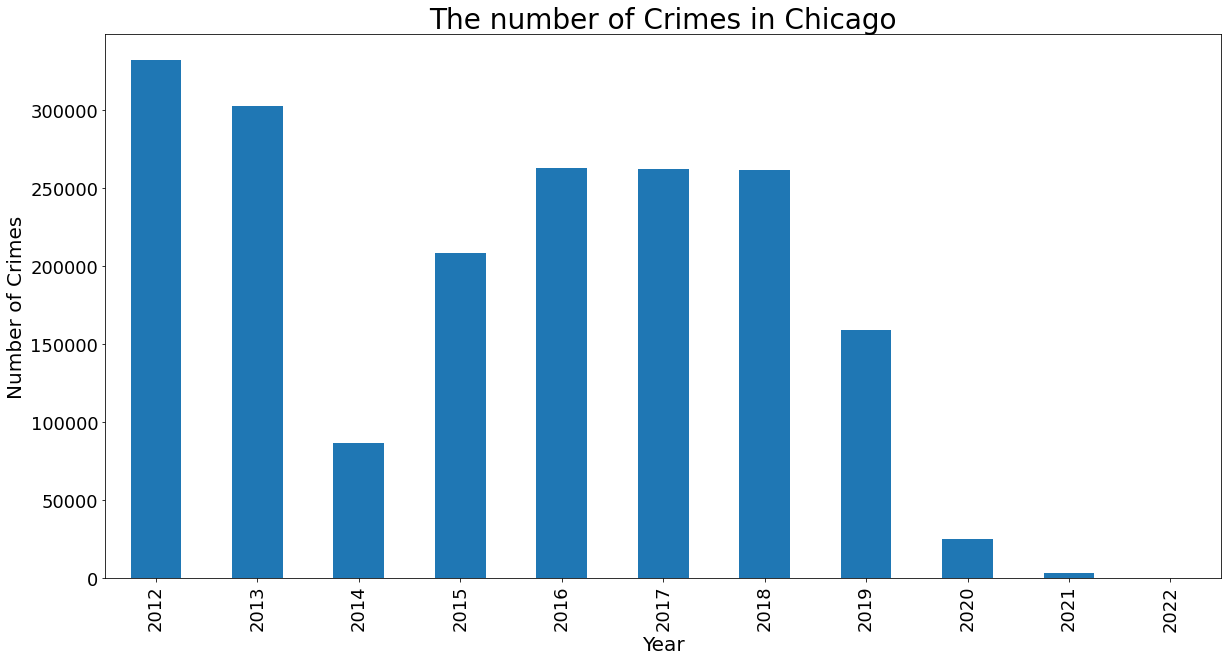

In [173]:
number_of_crimes_per_year = number_of_crimes_per_year.sort_values(by = "Year")

number_of_crimes_per_year.plot(figsize = (20,10), kind = "bar",
                               x = "Year", y = "count", legend = False)

plt.xlabel("Year", fontsize = 20)
plt.ylabel("Number of Crimes", fontsize = 20)
plt.title("The number of Crimes in Chicago", fontsize = 28)
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.show()

The highest number of accident were seen in 2012.

#### b. Find out at which hour of the day crime is highest.


In [175]:
from pyspark.sql.functions import date_format
df2 = df1.withColumn("HourOfDay", date_format("Date&time","H"))

In [176]:
df2.printSchema()

root
 |-- ID: string (nullable = true)
 |-- CaseNumber: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- PrimaryType: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- LocationDescription: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- CommunityArea: string (nullable = true)
 |-- FBICode: string (nullable = true)
 |-- XCoordinate: double (nullable = true)
 |-- YCoordinate: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- UpdatedOn: date (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- Date&time: timestamp (nullable = true)
 |-- HourOfDay: string (nullable = true)



In [177]:
import seaborn as sns

In [178]:
temp = df2.filter(df2["Domestic"] == "true")
temp = temp.select(df2['HourOfDay'].cast('int').alias('HourOfDay'))
hourlyCount  = temp.groupBy(["HourOfDay"]).count().collect()


hours = [item[0] for item in hourlyCount]
count = [item[1] for item in hourlyCount]

crime_byHour = {"count": count, "hours": hours}
crime_byHour = pd.DataFrame(crime_byHour)
crime_byHour = crime_byHour.sort_values(by = "hours", ascending  = False)
crime_byHour




,count,hours
15,14113,23
1,14998,22
18,14075,21
7,13218,20
9,12693,19
23,12806,18
11,12053,17
5,11905,16
10,11183,15
20,10529,14


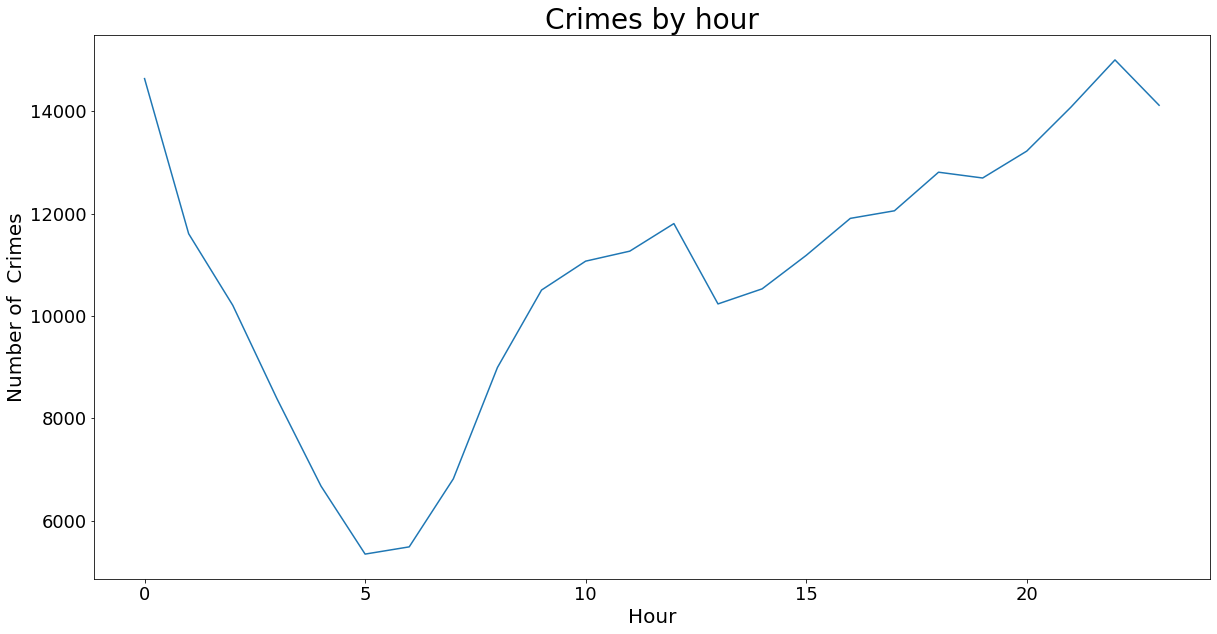

In [179]:
crime_byHour.plot(figsize = (20,10), kind = "line", x = "hours", y = "count", legend = False)

plt.ylabel("Number of  Crimes", fontsize = 20)
plt.xlabel("Hour", fontsize = 20)
plt.title("Crimes by hour", fontsize = 28)
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.show()

In the chart we can see that around 10pm at night is the highest crimes that occur.


#### c. Find top ten crimes and present them as a bar chart.

In [180]:
type_crime = Chicago_crimes.groupBy('PrimaryType').count()
type_crime= pd.DataFrame(type_crime.orderBy('count',ascending=False).rdd.map(lambda e: e.asDict()).collect())
type_crime = type_crime.head(10)

[Text(0.5, 1.0, 'Top 10 Crimes')]

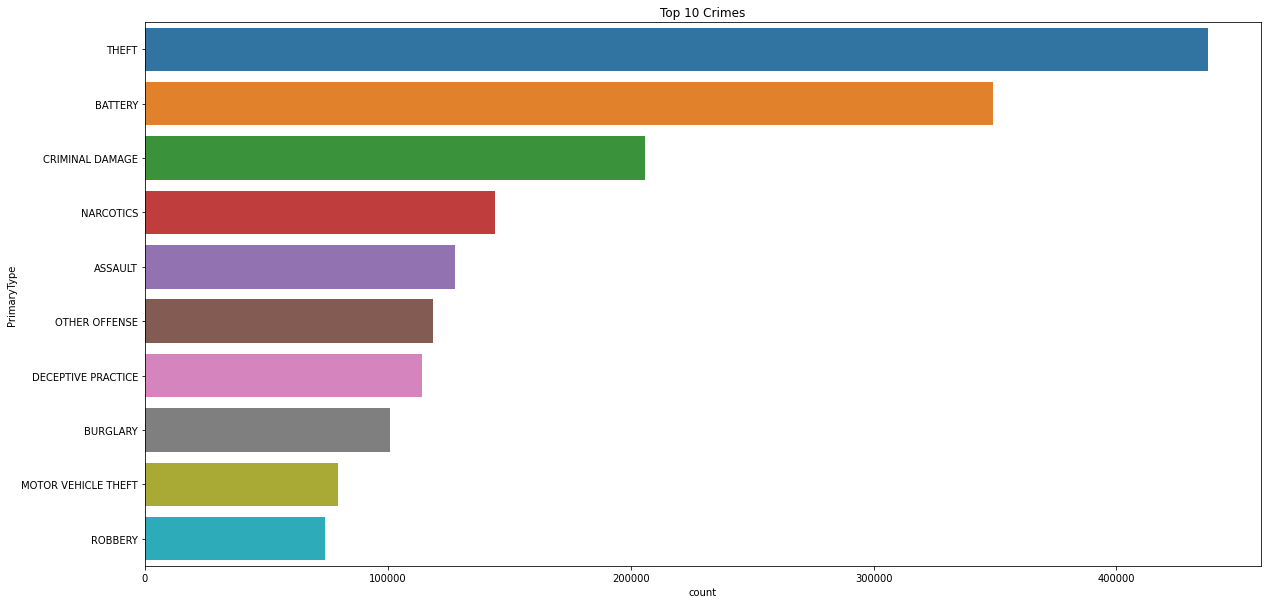

In [181]:
plt.subplots(figsize=(20,10))
sns.barplot(data = type_crime, x = 'count', y = 'PrimaryType').set(title='Top 10 Crimes')

Theft was the highest recored crime.
